In [1]:
import sncosmo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from iminuit import Minuit
from tqdm import tqdm

In [2]:
sns.set_style('ticks')

# DES

In [3]:
des = sncosmo.read_snana_ascii('data/SALT2mu_DES+LOWZ_C11.FITRES',
                               default_tablename='SN')[1]['SN']

`IDSAMPLE==0` is the low redshift sample, `IDSAMPLE==1` is the DES sample.

# PS1 + JLA

In [4]:
ps = sncosmo.read_snana_ascii('data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-c11.fitres',
                               default_tablename='SN')[1]['SN']

* `IDSAMPLE==0` is Pantheon low-z
* `IDSAMPLE==1` is PS1
* `IDSAMPLE==2` is SDSS
* `IDSAMPLE==3` is SNLS
* `IDSAMPLE==4` is high-z

# Standardize data set

In [5]:
lowz_cut = des['IDSAMPLE']==0
lowz_df = {'name': des[lowz_cut]['CID'],
           'x1': des[lowz_cut]['x1'],
           'c': des[lowz_cut]['c'],
           'mass': des[lowz_cut]['HOST_LOGMASS'],
           'x1_err': des[lowz_cut]['x1ERR'],
           'c_err': des[lowz_cut]['cERR'],
           'mass_err': des[lowz_cut]['HOST_LOGMASS_ERR'],
           'set': ['lowz' for _ in des[lowz_cut]]}
lowz_df = pd.DataFrame(lowz_df)

des_cut = des['IDSAMPLE']==1
des_df = {'name': des[des_cut]['CID'],
           'x1': des[des_cut]['x1'],
           'c': des[des_cut]['c'],
           'mass': des[des_cut]['HOST_LOGMASS'],
           'x1_err': des[des_cut]['x1ERR'],
           'c_err': des[des_cut]['cERR'],
           'mass_err': des[des_cut]['HOST_LOGMASS_ERR'],
           'set': ['DES' for _ in des[des_cut]]}
des_df = pd.DataFrame(des_df)

ps1_cut = ps['IDSAMPLE']==1
ps1_df = {'name': ps[ps1_cut]['CID'],
           'x1': ps[ps1_cut]['x1'],
           'c': ps[ps1_cut]['c'],
           'mass': ps[ps1_cut]['HOST_LOGMASS'],
           'x1_err': ps[ps1_cut]['x1ERR'],
           'c_err': ps[ps1_cut]['cERR'],
           'mass_err': ps[ps1_cut]['HOST_LOGMASS_ERR'],
           'set': ['PS1' for _ in ps[ps1_cut]]}
ps1_df = pd.DataFrame(ps1_df)

sdss_cut = ps['IDSAMPLE']==2
sdss_df = {'name': ps[sdss_cut]['CID'],
           'x1': ps[sdss_cut]['x1'],
           'c': ps[sdss_cut]['c'],
           'mass': ps[sdss_cut]['HOST_LOGMASS'],
           'x1_err': ps[sdss_cut]['x1ERR'],
           'c_err': ps[sdss_cut]['cERR'],
           'mass_err': ps[sdss_cut]['HOST_LOGMASS_ERR'],
           'set': ['SDSS' for _ in ps[sdss_cut]]}
sdss_df = pd.DataFrame(sdss_df)

snls_cut = ps['IDSAMPLE']==3
snls_df = {'name': ps[snls_cut]['CID'],
           'x1': ps[snls_cut]['x1'],
           'c': ps[snls_cut]['c'],
           'mass': ps[snls_cut]['HOST_LOGMASS'],
           'x1_err': ps[snls_cut]['x1ERR'],
           'c_err': ps[snls_cut]['cERR'],
           'mass_err': ps[snls_cut]['HOST_LOGMASS_ERR'],
           'set': ['SNLS' for _ in ps[snls_cut]]}
snls_df = pd.DataFrame(snls_df)

df = pd.concat([lowz_df, des_df, ps1_df, sdss_df, snls_df])
df = df[df.mass > 7]

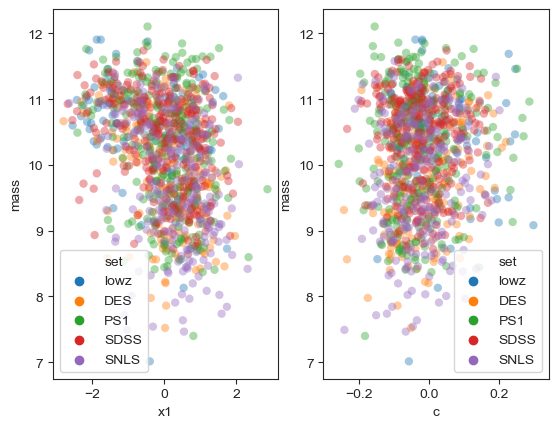

In [6]:
plt.subplot(121)
sns.scatterplot(df.x1, df.mass, hue=df.set, alpha=0.4, linewidth=0)
plt.subplot(122)
sns.scatterplot(df.c, df.mass, hue=df.set, alpha=0.4, linewidth=0)

In [7]:
alpha = 0.14
beta = -3.1
gamma = 0.1
sig_int = 0.05
mag = 19.1
df['mu'] = mag + alpha * df.x1 \
            + beta * df.c \
            + gamma/2. * np.sign(df.mass - 10) \
            + np.random.randn(len(df)) * sig_int

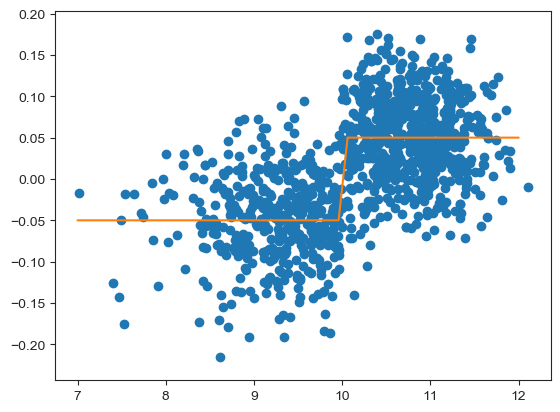

In [8]:
plt.scatter(df.mass, df.mu - mag - alpha * df.x1 - beta * df.c)
plt.plot(np.linspace(7, 12), gamma/2 * np.sign(np.linspace(7, 12)-10), color='C1')

In [9]:
def fit_simultaneous(df):
    
    def chisq(mag, alpha, beta, gamma):
        model = mag + alpha * df.x1 + beta * df.c + gamma/2. * np.sign(df.mass - 10)
        return np.sum((model - df.mu)**2)
    
    m = Minuit(chisq, mag=0, alpha=0, beta=0, gamma=0,
               pedantic=False, print_level=0)
    m.migrad()
    resids = df.mu - m.values['mag'] - m.values['alpha'] * df.x1 - m.values['beta'] * df.c - m.values['gamma']/2. * np.sign(df.mass - 10)
    
    return m.values, np.std(resids)

def fit_separate(df):
    
    def lin_chisq(mag, alpha, beta):
        model = mag + alpha * df.x1 + beta * df.c
        return np.sum((model - df.mu)**2)
    
    m_lin = Minuit(lin_chisq, mag=0, alpha=0, beta=0,
                   pedantic=False, print_level=0)
    m_lin.migrad()
    resids = df.mu - m_lin.values['mag'] - m_lin.values['alpha'] * df.x1 - m_lin.values['beta'] * df.c
    
    def step_chisq(gamma):
        model = gamma/2. * np.sign(df.mass - 10)
        return np.sum((model - resids)**2)
    
    m = Minuit(step_chisq, gamma=0, pedantic=False, print_level=0)
    m.migrad()
    
    resids = resids - m.values['gamma']/2. * np.sign(df.mass - 10)
    return m_lin.values, m.values, np.std(resids)

In [44]:
alpha = 0.14
beta = 2.8
gamma = 0.07
sig_int = 0.05
mag = 19.1

truth = {'alpha': alpha,
         'beta': beta,
         'gamma': gamma,
         'sig_int': sig_int,
         'mag': mag}

subset_vals = {k: {'alpha': [],
                   'beta': [],
                   'gamma': [],
                   'sig_int': [],
                   'alpha_sim': [],
                   'beta_sim': [],
                   'gamma_sim': [],
                   'sig_int_sim': []} for k in df.set.unique()}
for trial in tqdm(range(50)):
    df['mu'] = mag + alpha * df.x1 \
            + beta * df.c \
            + gamma/2. * np.sign(df.mass - 10) \
            + np.random.randn(len(df)) * sig_int
    for subset in df.set.unique():
        vals_sim, std_resid_sim = fit_simultaneous(df[df.set==subset])
        vals_lin, val_step, std_resid_sep = fit_separate(df[df.set==subset])
        subset_vals[subset]['alpha_sim'].append(vals_sim['alpha'])
        subset_vals[subset]['beta_sim'].append(vals_sim['beta'])
        subset_vals[subset]['gamma_sim'].append(vals_sim['gamma'])
        subset_vals[subset]['sig_int_sim'].append(std_resid_sim)
        subset_vals[subset]['alpha'].append(vals_lin['alpha'])
        subset_vals[subset]['beta'].append(vals_lin['beta'])
        subset_vals[subset]['gamma'].append(val_step['gamma'])
        subset_vals[subset]['sig_int'].append(std_resid_sep)

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


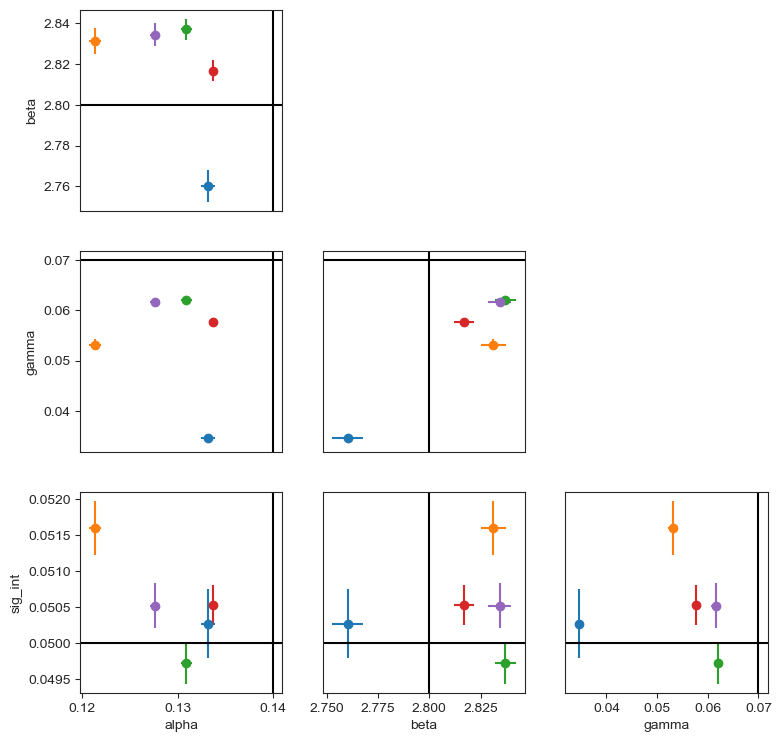

In [45]:
plt.figure(figsize=(12, 12))
for i, param1 in enumerate(['alpha', 'beta', 'gamma', 'sig_int']):
    for j, param2 in enumerate(['alpha', 'beta', 'gamma', 'sig_int']):
        if i >= j:
            continue
        plt.subplot(4, 4, i+4*j+1) 
        for k, (subset, vals) in enumerate(subset_vals.items()):
            plt.errorbar(np.mean(vals[param1]), np.mean(vals[param2]),
                         xerr=np.std(vals[param1])/np.sqrt(50),
                         yerr=np.std(vals[param2])/np.sqrt(50),
                         marker='o', c='C'+str(k), label=subset)
        plt.axhline(truth[param2], color='k')
        plt.axvline(truth[param1], color='k')
        if i==0:
            plt.ylabel(param2)
        else:
            plt.yticks([])
        if j==3:
            plt.xlabel(param1)
        else:
            plt.xticks([])

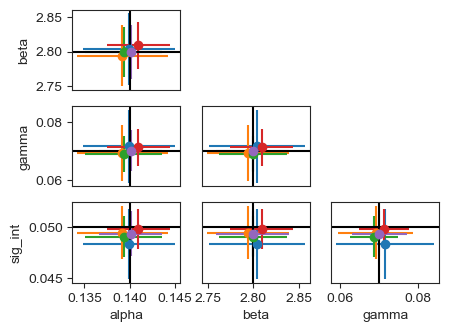

In [46]:
for i, param1 in enumerate(['alpha', 'beta', 'gamma', 'sig_int']):
    for j, param2 in enumerate(['alpha', 'beta', 'gamma', 'sig_int']):
        if i >= j:
            continue
        plt.subplot(4, 4, i+4*j+1) 
        for k, (subset, vals) in enumerate(subset_vals.items()):
            plt.errorbar(np.mean(vals[param1+'_sim']), np.mean(vals[param2+'_sim']),
                         xerr=np.std(vals[param1+'_sim']), yerr=np.std(vals[param2+'_sim']),
                         marker='o', c='C'+str(k), label=subset)
        plt.axhline(truth[param2], color='k')
        plt.axvline(truth[param1], color='k')
        if i==0:
            plt.ylabel(param2)
        else:
            plt.yticks([])
        if j==3:
            plt.xlabel(param1)
        else:
            plt.xticks([])

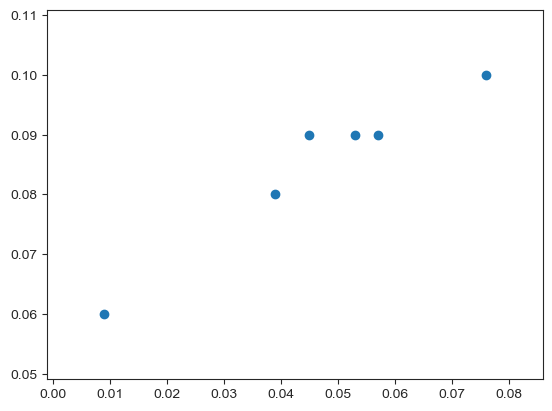

In [35]:
plt.scatter([0.009, 0.053, 0.076, 0.057, 0.039, 0.045],
            [0.06, 0.09, 0.10, 0.09, 0.08, 0.09])
# 0.009 
# 0.030 
# 0.015 
# 0.016 
# 0.020 